### 1. Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### 1.2 Import the data

In [120]:
path = 'dataset/A_DeviceMotion_data/'

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

for i in list_of_directories:
    if i == path + '.DS_Store':
        continue

    list_of_csv = os.listdir(i)
    list_of_csv = [m for m in list_of_csv if m.endswith('.csv')]
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[2].split('_')[0]
        k['trial'] = int(i.split('/')[2].split('_')[1])
        
        list_of_dfs.append(k)

df = pd.concat(list_of_dfs, ignore_index=True).set_index('time')
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,gyro_x,gyro_y,gyro_z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject,activity,trial
time,,,,,,,,,,,,,,,
0,-2.116381,-1.077507,-2.261502,-0.404768,0.880780,0.245713,-1.264215,-1.027909,-0.947909,0.282683,-0.254346,-0.407670,12,dws,11
1,-2.148154,-1.049759,-2.284278,-0.417081,0.867303,0.271686,-1.162024,-0.269118,-0.848823,0.256712,0.079154,-0.560291,12,dws,11
2,-2.153824,-1.026749,-2.297008,-0.432082,0.855621,0.284961,-0.665042,0.520170,-0.726722,0.253600,0.346680,-0.463275,12,dws,11
3,-2.142509,-1.012749,-2.290595,-0.445311,0.848291,0.286507,-0.079809,0.055322,-0.604534,0.411818,0.459372,-0.510293,12,dws,11
4,-2.130486,-1.007262,-2.274149,-0.452661,0.845372,0.283600,0.456097,-0.186877,-0.441315,0.311594,0.477305,-0.925049,12,dws,11


### 1.3 Data Preprocessing

#### 1.3.0 Feature engineering

In [121]:

# combine dfs and drop unnecessary columns

df.insert(0, 'accel_x', df["userAcceleration.x"] + df["gravity.x"])
df.insert(1, 'accel_y', df["userAcceleration.y"] + df["gravity.y"])
df.insert(2, 'accel_z', df["userAcceleration.z"] + df["gravity.z"])
df.insert(3, 'accel_norm', np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2))

# drop userAcceleration and gravity columns since we have combined them
# PCA shows that with these colums we can reduce the dimensionality of the data and without them, we cannot
df.drop(['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'gravity.x', 'gravity.y', 'gravity.z'], axis=1, inplace=True)

print(df.head())

df_X = df.iloc[:, :-3]
df_y = df.iloc[:, -3:]

       accel_x   accel_y   accel_z  accel_norm  attitude.roll  attitude.pitch  \
time                                                                            
0    -0.122085  0.626434 -0.161957    0.658448      -2.116381       -1.077507   
1    -0.160369  0.946457 -0.288605    1.002393      -2.148154       -1.049759   
2    -0.178482  1.202301 -0.178314    1.228487      -2.153824       -1.026749   
3    -0.033493  1.307663 -0.223786    1.327096      -2.142509       -1.012749   
4    -0.141067  1.322677 -0.641449    1.476764      -2.130486       -1.007262   

      attitude.yaw    gyro_x    gyro_y    gyro_z  subject activity  trial  
time                                                                       
0        -2.261502 -1.264215 -1.027909 -0.947909       12      dws     11  
1        -2.284278 -1.162024 -0.269118 -0.848823       12      dws     11  
2        -2.297008 -0.665042  0.520170 -0.726722       12      dws     11  
3        -2.290595 -0.079809  0.055322 -0.604534    

#### 1.3.4 Data correlation

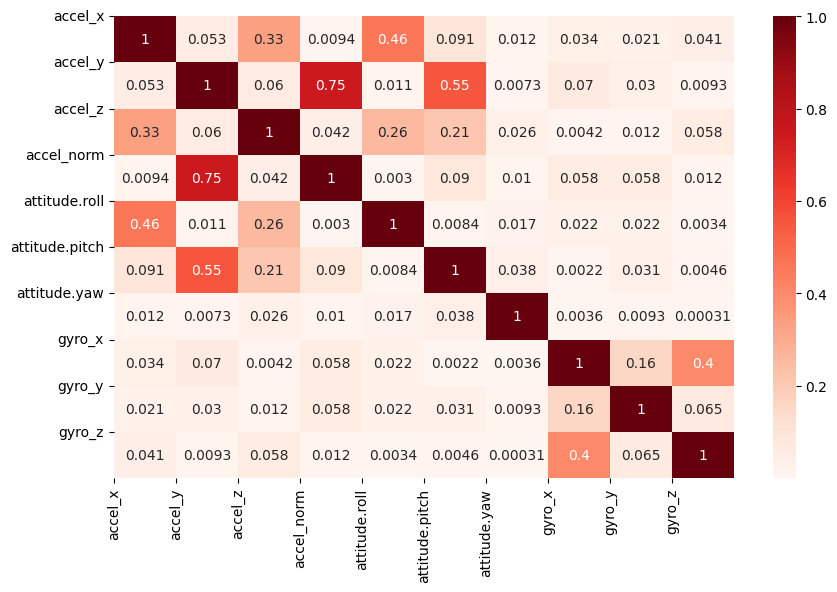

In [13]:
import seaborn as sns
correlation_matrix = df_X.corr()
correlation_matrix = correlation_matrix.abs()

# visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

#### Feature selection

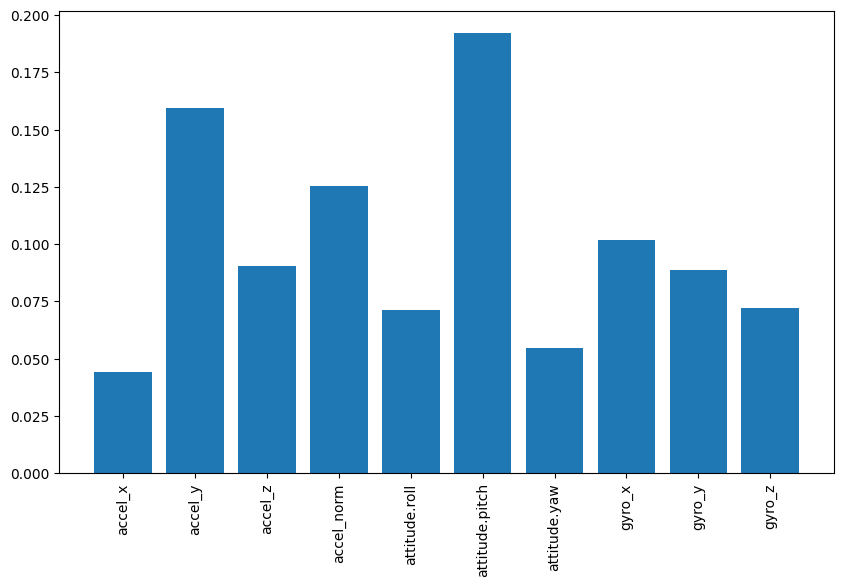

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=15)
clf.fit(df_X, df_y.activity)

feature_importance = clf.feature_importances_

# visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(df_X.columns, feature_importance)
plt.xticks(rotation=90)
plt.show()

##### 1.3.1 Data scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def minmax_scaling(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def standard_scaling(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

##### 1.3.2 Graph the best number of components to use

In [9]:
from sklearn.decomposition import PCA

def pca_best_components(df):
    X = df.iloc[:,:-3]
    normalized_X = (X - X.mean()) / X.std()
    # apply PCA
    pca = PCA()
    pca.fit(normalized_X)

    explained_variance = pca.explained_variance_ratio_

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance))
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Number of Components')
    plt.title('Explained Variance by Principal Components')
    plt.grid()
    plt.show()

    # find the number of components that explain 95% of the variance
    cumsum = np.cumsum(explained_variance)
    best_n_components = np.argmax(cumsum >= 0.95) + 1
    print("Best number of components:", best_n_components)
    return best_n_components

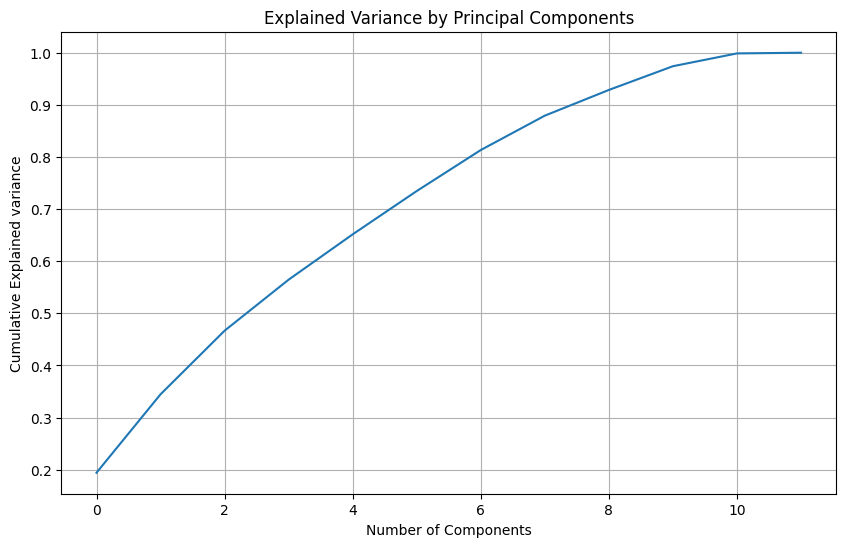

Best number of components: 10


In [109]:
best_n_c = pca_best_components(df)

if best_n_c == len(df_X.columns):
    print("PCA not needed")

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#### 1.3.3 Simple Test train split

In [19]:
def y_to_categorical(y_train):
    encoder = LabelEncoder()
    encoder.fit(y_train)

    y_catagorical = encoder.transform(y_train)
    y_catagorical = to_categorical(y_catagorical)

    return y_catagorical

In [55]:
train_df = df[(df.trial < 10)]
test_df = df[(df.trial >= 10)]


# all except last 3 cols (activity, subject, trial)
X_train = train_df.iloc[:,:-3]
y_train = train_df.activity

y_catagorical = y_to_categorical(y_train)

### 1.3 Data Analysis

1.3.1 Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [96]:
def test_results(model, df, scaling_func=None):
    correct = 0
    total = 0

    results = []

    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        if scaling_func:
            k = scaling_func(k)
        preds = model.predict(k)
        print(i + ': ' + str(((preds == i).sum() / len(preds))*100) + '%')
        correct += (preds == i).sum()
        total += len(preds)
        results.append((preds == i).sum() / len(preds))

    print('Total: ' + str((correct / total)*100) + '%')
    return results

In [78]:
test_results(dtc, test_df)

dws: 48.057950404408494%
ups: 51.72623085436824%
sit: 94.70327791703883%
std: 90.3395375623384%
wlk: 59.19230297830617%
jog: 60.4601391118245%
Total: 76.74605257996674%


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_matrix(model, df):
    y_true = df.activity
    y_pred = model.predict(df.iloc[:,:-3])

    cm = confusion_matrix(y_true, y_pred, labels=activities)
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=activities)
    disp.plot()

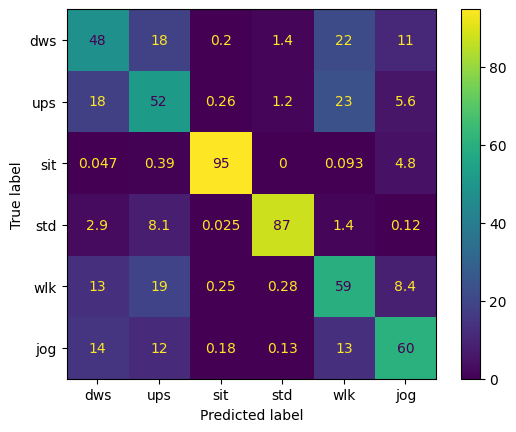

In [36]:
show_confusion_matrix(dtc, test_df)

### 1.3.1.1 Decision Tree with scaling

In [30]:
dtc = DecisionTreeClassifier()
X_scaled = minmax_scaling(X_train)
dtc.fit(X_scaled, y_train)

test_results(dtc, test_df, minmax_scaling)

dws: 10.301306550528842%
ups: 16.48041700881859%
sit: 2.4442715686556986%
std: 0.020830525296834986%
wlk: 21.889937492339747%
jog: 46.08747993579455%
Total: 11.33489630950549%


In [31]:
dtc = DecisionTreeClassifier()
X_scaled = standard_scaling(X_train)
dtc.fit(X_scaled, y_train)

test_results(dtc, test_df, standard_scaling)

dws: 30.566171895831484%
ups: 43.11471312792317%
sit: 8.979936804295003%
std: 6.080062736640894%
wlk: 51.02647383257752%
jog: 17.007758159443554%
Total: 21.621572691969984%


Scaling is probably a bad idea due to the fact that we are dealing with time series data, the scaling could interrupt the models' ability to capture patterns over time

### 2.2 Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [39]:
test_results(rfc, test_df)

dws: 62.74108968091725%
ups: 59.14170445214039%
sit: 94.96259160015751%
std: 92.56472779404737%
wlk: 70.39772030886138%
jog: 71.7328785446763%
Total: 82.22310730525408%


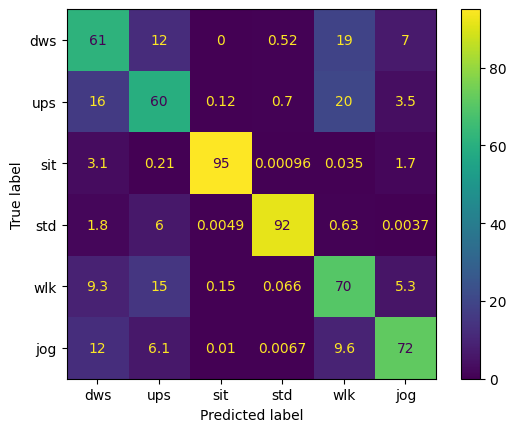

In [37]:
show_confusion_matrix(rfc, test_df)

#### NN testing

In [113]:
import tensorflow as tf
from tensorflow import keras

def nn_compile(model, lr):
    optimizer = keras.optimizers.legacy.Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

def nn_train(model, train_X, train_y, val_X, val_y, epochs=10):
    early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=200, validation_data=(val_X, val_y), callbacks=[early_stopping])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.show()

def create_base_nn(input):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[input]),
        keras.layers.Dense(48, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

def create_nn_simple(input):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[input]),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

In [114]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_catagorical, shuffle=True, stratify=y_train)

Epoch 1/10
4056/4056 [==============================] - 4s 916us/step - loss: 0.5432 - accuracy: 0.7881 - val_loss: 0.4982 - val_accuracy: 0.8112
Epoch 2/10
4056/4056 [==============================] - 3s 688us/step - loss: 0.4771 - accuracy: 0.8190 - val_loss: 0.4765 - val_accuracy: 0.8200
Epoch 3/10
4056/4056 [==============================] - 3s 670us/step - loss: 0.4608 - accuracy: 0.8261 - val_loss: 0.4624 - val_accuracy: 0.8292
Epoch 4/10
4056/4056 [==============================] - 3s 661us/step - loss: 0.4520 - accuracy: 0.8302 - val_loss: 0.4523 - val_accuracy: 0.8307
Epoch 5/10
4056/4056 [==============================] - 3s 660us/step - loss: 0.4468 - accuracy: 0.8321 - val_loss: 0.4505 - val_accuracy: 0.8329
Epoch 6/10
4056/4056 [==============================] - 3s 672us/step - loss: 0.4421 - accuracy: 0.8345 - val_loss: 0.4400 - val_accuracy: 0.8358
Epoch 7/10
4056/4056 [==============================] - 3s 660us/step - loss: 0.4392 - accuracy: 0.8359 - val_loss: 0.4408 -

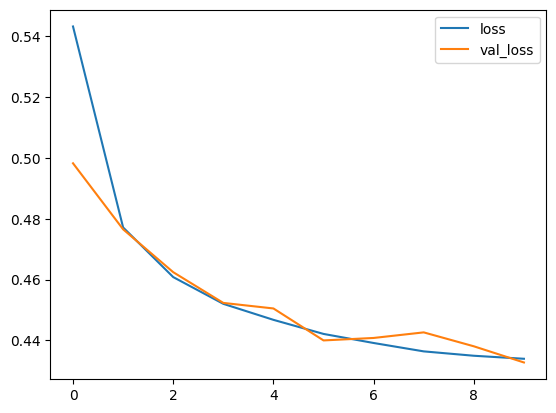

In [63]:

# 1 input layer, 1 hidden layer, 6 nodes, softmax activation
model = create_nn_simple(X_train.shape[1])

nn_compile(model, 0.01)
nn_train(model, train_X, train_y, val_X, val_y)

In [101]:
def nn_test_results(model, df):
    correct = 0
    total = 0

    results = []

    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        preds = model.predict(k, verbose=0)
        encoder = LabelEncoder()
        encoder.fit(y_train)
        l = []
        for j in range(len(preds)):
            l.append(list(encoder.classes_)[np.argmax(preds[j])])
        accuracy = sum([l[j] == i for j in range(len(l))])/len(l)
        print(i + ': ' + str(accuracy*100) + '%')
        correct += sum([l[j] == i for j in range(len(l))])
        total += len(l)
        results.append(accuracy)
    print('total: ' + str(correct / total * 100) + '%')
    return results

In [65]:
nn_test_results(model, test_df)

dws: 49.37338903208604%
ups: 46.61358848941411%
sit: 89.36717857108556%
std: 92.1971302888091%
wlk: 76.19653143767619%
jog: 69.95385232744783%
total: 79.38983582715535%


In [67]:
def show_confusion_matrix_nn(model, df):
    preds = model.predict(df.iloc[:,:-3], verbose=0)
    encoder = LabelEncoder()
    encoder.fit(y_train)
    l = []
    for j in range(len(preds)):
        l.append(list(encoder.classes_)[np.argmax(preds[j])])
    
    y_true = df.activity
    y_pred = l

    cm = confusion_matrix(y_true, y_pred, labels=activities)
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=activities)

    disp.plot()


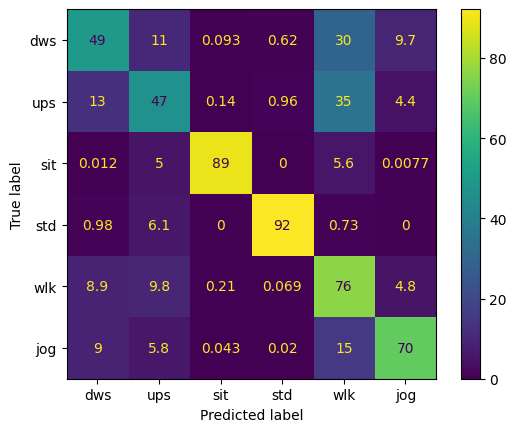

In [68]:
show_confusion_matrix_nn(model, test_df)

#### improvement: Rolling features 

In [75]:
def create_feature_columns(k):
    feature_df = df.copy()
    cols = feature_df.iloc[:,:-3].columns

    j = 1
    for i in cols:
        feature_df.insert(j, f"{i}_rmean", feature_df[i].rolling(k).mean())
        feature_df.insert(j+1, f"{i}_rstd", feature_df[i].rolling(k).std())
        feature_df.insert(j+2, f"{i}_rmed", feature_df[i].rolling(k).median())
        j +=4

    for i in range(k):
        feature_df = feature_df.drop([i])

    return feature_df

In [76]:
rolling_df = create_feature_columns(150)

rolling_train_fd = rolling_df[(rolling_df.trial < 10)]
rolling_test_fd = rolling_df[(rolling_df.trial >= 10)]

rolling_X = rolling_train_fd.iloc[:,:-3]
rolling_y = rolling_train_fd.activity

rolling_y_catagorical = y_to_categorical(rolling_y)

In [77]:
rdt = DecisionTreeClassifier()
rdt.fit(rolling_X, rolling_y)

DecisionTreeClassifier()

In [81]:
test_results(rdt, rolling_test_fd)

dws: 90.10686699820126%
ups: 88.07407103937072%
sit: 91.63557863531004%
std: 99.71542474779199%
wlk: 85.44882604747698%
jog: 89.35523114355232%
Total: 91.87106019966497%


In [82]:
rrfc = RandomForestClassifier(n_estimators=10)
rrfc.fit(rolling_X, rolling_y)

RandomForestClassifier(n_estimators=10)

In [83]:
test_results(rrfc, rolling_test_fd)

dws: 98.58745106337953%
ups: 94.55528698430906%
sit: 99.9910466469693%
std: 96.28257553421953%
wlk: 90.4024516798547%
jog: 95.99300486618006%
Total: 96.29525626252747%


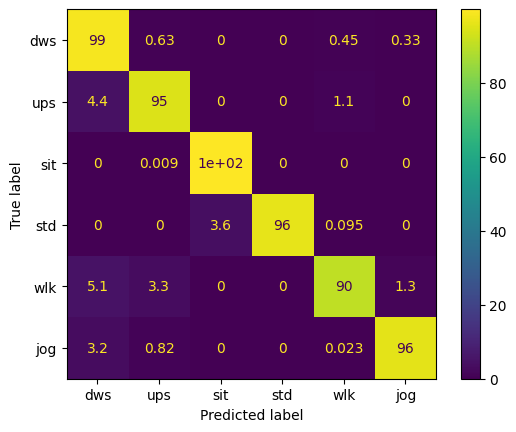

In [119]:
show_confusion_matrix(rrfc, rolling_test_fd)

Epoch 1/10
3934/3934 [==============================] - 5s 1ms/step - loss: 0.0770 - accuracy: 0.9749 - val_loss: 0.0375 - val_accuracy: 0.9872
Epoch 2/10
3934/3934 [==============================] - 5s 1ms/step - loss: 0.0325 - accuracy: 0.9889 - val_loss: 0.0306 - val_accuracy: 0.9900
Epoch 3/10
3934/3934 [==============================] - 4s 979us/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0176 - val_accuracy: 0.9935
Epoch 4/10
3934/3934 [==============================] - 4s 1ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0189 - val_accuracy: 0.9935
Epoch 5/10
3934/3934 [==============================] - 4s 991us/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0143 - val_accuracy: 0.9950
Epoch 6/10
3934/3934 [==============================] - 4s 989us/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0148 - val_accuracy: 0.9951
Epoch 7/10
3934/3934 [==============================] - 4s 989us/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0136 - val_a

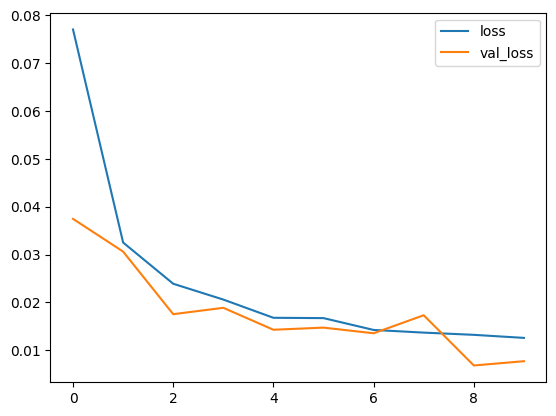

In [84]:
rolling_nn = create_nn_simple(rolling_X.shape[1])

train_X, val_X, train_y, val_y = train_test_split(rolling_X, rolling_y_catagorical, shuffle=True)

nn_compile(rolling_nn, 0.01)
nn_train(rolling_nn, train_X, train_y, val_X, val_y)

In [85]:
nn_test_results(rolling_nn, rolling_test_fd)

dws: 94.55084118082743%
ups: 89.79474783891189%
sit: 90.46666865630067%
std: 95.59677481380831%
wlk: 91.47749383837073%
jog: 96.44540754257908%
total: 92.66345834180602%


#### Sliding window

In [86]:
# sample rate: 50hz
# window size: 150 samples = 3 seconds
# stride size: 5 samples = 0.1 seconds
def sliding_window(df, window_size=150, stride_size=5, catagorical=True):
    X = []
    y = []

    data_len = len(df)
    x_data = df.iloc[:,:-3].values
    y_data = df.iloc[:,-3:].activity.values

    for i in range(0, data_len - window_size, stride_size):
        x_vals = x_data[i:i+window_size]
        y_vals = y_data[i:i+window_size]
        # do not allow overlapping windows
        if len(np.unique(y_vals)) == 1:
            X.append(x_vals)
            y.append(y_vals[0])

    if catagorical:
        # one hot encode y
        encoder = LabelEncoder()
        encoder.fit(y)
        y = encoder.transform(y)
        y = to_categorical(y)

    return np.array(X), np.array(y)

In [87]:
X_train_window, y_train_window = sliding_window(train_df)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False)
X_test_window_cat, y_test_window_cat = sliding_window(test_df)

print(f"[INFO] -- X_train_window shape: {X_train_window.shape}")
print(f"[INFO] -- y_train_window shape: {y_train_window.shape}")
print(f"[INFO] -- X_test_window shape: {X_test_window.shape}")  
print(f"[INFO] -- y_test_window shape: {y_test_window.shape}")

[INFO] -- X_train_window shape: (216081, 150, 10)
[INFO] -- y_train_window shape: (216081, 6)
[INFO] -- X_test_window shape: (66105, 150, 10)
[INFO] -- y_test_window shape: (66105,)


Epoch 1/50
811/811 [==============================] - 14s 15ms/step - loss: 0.3044 - accuracy: 0.9501 - val_loss: 0.1863 - val_accuracy: 0.9782
Epoch 2/50
811/811 [==============================] - 12s 15ms/step - loss: 0.1561 - accuracy: 0.9747 - val_loss: 0.1371 - val_accuracy: 0.9782
Epoch 3/50
811/811 [==============================] - 15s 19ms/step - loss: 0.1449 - accuracy: 0.9764 - val_loss: 0.1419 - val_accuracy: 0.9710
Epoch 4/50
811/811 [==============================] - 12s 15ms/step - loss: 0.1532 - accuracy: 0.9777 - val_loss: 0.0989 - val_accuracy: 0.9865
Epoch 5/50
811/811 [==============================] - 12s 14ms/step - loss: 0.1190 - accuracy: 0.9808 - val_loss: 0.0975 - val_accuracy: 0.9875
Epoch 6/50
811/811 [==============================] - 12s 15ms/step - loss: 0.1103 - accuracy: 0.9824 - val_loss: 0.1004 - val_accuracy: 0.9857
Epoch 7/50
811/811 [==============================] - 12s 15ms/step - loss: 0.1071 - accuracy: 0.9831 - val_loss: 0.0818 - val_accuracy:

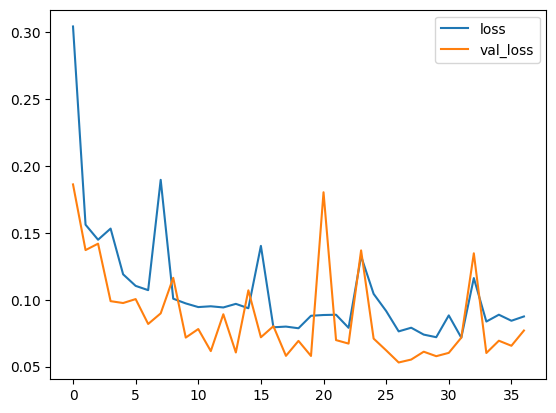

In [122]:
cnn_sliding = keras.Sequential()

cnn_sliding.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.2))
cnn_sliding.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.2))
cnn_sliding.add(keras.layers.Flatten())
cnn_sliding.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding, train_X, train_y, val_X, val_y, epochs=50)

In [145]:
def cnn_test_results(cnn_sliding, x_test, y_test):
    xs = {}
    for activity in activities:
        xs[activity] = []

    label_encoder = LabelEncoder()
    label_encoder.fit(y_test)

    for i in range(len(x_test)):
        xs[y_test[i]].append(x_test[i])

    for activity in activities:
        xs[activity] = np.array(xs[activity])

    total = 0
    correct = 0
    results = []
    for activity in activities:
        preds = cnn_sliding.predict(xs[activity], verbose=0)
        preds = np.argmax(preds, axis=1)
        accuracy = sum(preds == label_encoder.transform([activity])[0])/len(preds)
        print(activity + ': ' + str(accuracy*100) + '%')
        total += len(preds)
        correct += sum(preds == label_encoder.transform([activity])[0])
        results.append(accuracy)
    print('total: ' + str(correct / total * 100) + '%')
    return results
     

In [123]:
cnn_test_results(cnn_sliding, X_test_window, y_test_window)

dws: 99.1948110042496%
ups: 90.68557071069634%
sit: 95.28251983649916%
std: 95.55610115394059%
wlk: 88.85902948402948%
jog: 98.3532179465636%
total: 94.23795476892822%


Epoch 1/50
811/811 [==============================] - 33s 40ms/step - loss: 0.9816 - accuracy: 0.9444 - val_loss: 0.3318 - val_accuracy: 0.9700
Epoch 2/50
811/811 [==============================] - 31s 39ms/step - loss: 0.2390 - accuracy: 0.9754 - val_loss: 0.1962 - val_accuracy: 0.9828
Epoch 3/50
811/811 [==============================] - 34s 42ms/step - loss: 0.2344 - accuracy: 0.9783 - val_loss: 0.2893 - val_accuracy: 0.9738
Epoch 4/50
811/811 [==============================] - 38s 46ms/step - loss: 0.2038 - accuracy: 0.9805 - val_loss: 0.1614 - val_accuracy: 0.9858
Epoch 5/50
811/811 [==============================] - 40s 49ms/step - loss: 0.2233 - accuracy: 0.9791 - val_loss: 0.2026 - val_accuracy: 0.9845
Epoch 6/50
811/811 [==============================] - 34s 42ms/step - loss: 0.1762 - accuracy: 0.9823 - val_loss: 0.1750 - val_accuracy: 0.9824
Epoch 7/50
811/811 [==============================] - 33s 40ms/step - loss: 0.5266 - accuracy: 0.9648 - val_loss: 0.2054 - val_accuracy:

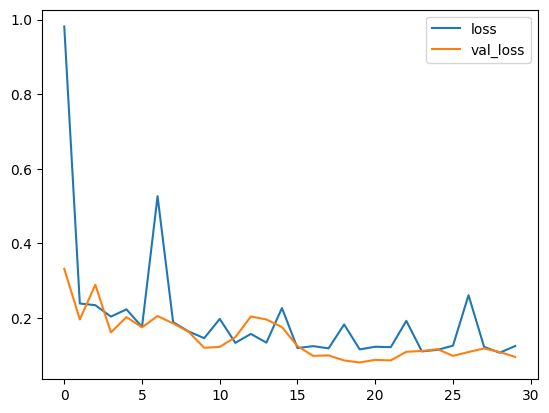

In [124]:
cnn_sliding = keras.Sequential()

cnn_sliding.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding.add(keras.layers.BatchNormalization())
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.2))

cnn_sliding.add(keras.layers.Conv1D(128, 3, activation='relu'))
cnn_sliding.add(keras.layers.BatchNormalization())
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.3))

cnn_sliding.add(keras.layers.Flatten())
cnn_sliding.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding, train_X, train_y, val_X, val_y, epochs=50)

In [125]:
cnn_test_results(cnn_sliding, X_test_window, y_test_window)

dws: 97.67389845672109%
ups: 96.06963388370423%
sit: 95.18634287088243%
std: 95.6665848269089%
wlk: 95.38544226044226%
jog: 98.03394387497899%
total: 95.84297708191514%


Epoch 1/50
811/811 [==============================] - 9s 11ms/step - loss: 0.2711 - accuracy: 0.9142 - val_loss: 0.0793 - val_accuracy: 0.9800
Epoch 2/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0933 - accuracy: 0.9732 - val_loss: 0.0788 - val_accuracy: 0.9757
Epoch 3/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0554 - accuracy: 0.9833 - val_loss: 0.0419 - val_accuracy: 0.9880
Epoch 4/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0501 - accuracy: 0.9853 - val_loss: 0.0650 - val_accuracy: 0.9794
Epoch 5/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0341 - val_accuracy: 0.9899
Epoch 6/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0557 - accuracy: 0.9844 - val_loss: 0.0855 - val_accuracy: 0.9727
Epoch 7/50
811/811 [==============================] - 9s 11ms/step - loss: 0.0416 - accuracy: 0.9878 - val_loss: 0.0395 - val_accuracy: 0.9876

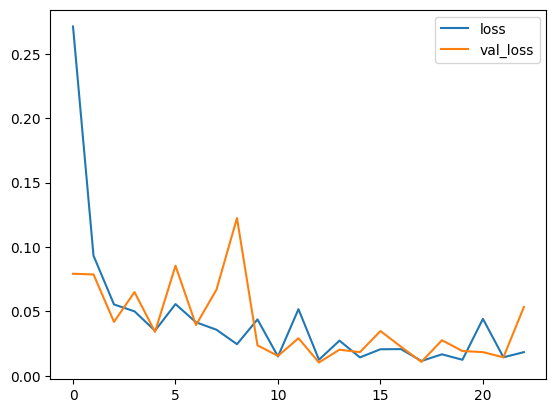

In [117]:
cnn_sliding = keras.Sequential()

cnn_sliding.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Flatten())
cnn_sliding.add(keras.layers.Dense(16, activation='relu'))
cnn_sliding.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding, train_X, train_y, val_X, val_y, epochs=50)

In [118]:
 cnn_test_results(cnn_sliding, X_test_window, y_test_window)

dws: 96.08588682621337%
ups: 93.61091170136396%
sit: 98.97090646790095%
std: 95.84458630002455%
wlk: 94.34121621621621%
jog: 98.08435557049235%
total: 96.56153089781408%


#### LSTM

Epoch 1/10
811/811 [==============================] - 22s 26ms/step - loss: 0.2485 - accuracy: 0.9200 - val_loss: 0.1166 - val_accuracy: 0.9661
Epoch 2/10
811/811 [==============================] - 19s 23ms/step - loss: 0.0949 - accuracy: 0.9720 - val_loss: 0.0809 - val_accuracy: 0.9769
Epoch 3/10
811/811 [==============================] - 19s 23ms/step - loss: 0.0640 - accuracy: 0.9806 - val_loss: 0.0698 - val_accuracy: 0.9796
Epoch 4/10
811/811 [==============================] - 19s 24ms/step - loss: 0.0476 - accuracy: 0.9851 - val_loss: 0.0489 - val_accuracy: 0.9849
Epoch 5/10
811/811 [==============================] - 19s 23ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.0458 - val_accuracy: 0.9855
Epoch 6/10
811/811 [==============================] - 19s 23ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.0433 - val_accuracy: 0.9853
Epoch 7/10
811/811 [==============================] - 19s 23ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0427 - val_accuracy:

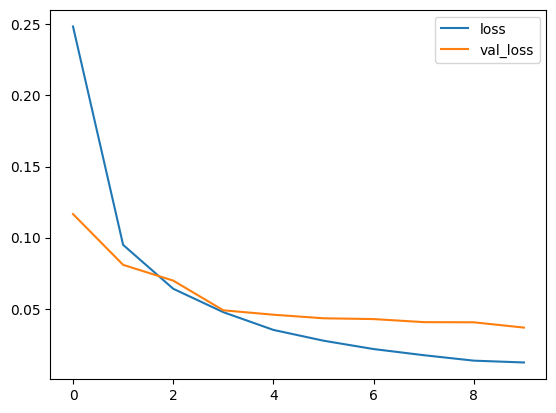

In [91]:
lstm = keras.Sequential()
lstm.add(keras.layers.Input((X_train_window.shape[1], X_train_window.shape[2])))
lstm.add(keras.layers.LSTM(6, input_shape=(X_train_window.shape[1], X_train_window.shape[2]), return_sequences=True))
lstm.add(keras.layers.Flatten())
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(6, activation='softmax'))

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(lstm, train_X, train_y, val_X, val_y)

In [92]:
cnn_test_results(lstm, X_test_window, y_test_window)

dws: 96.84634309997764%
ups: 92.76740847092606%
sit: 95.27290213993749%
std: 92.38276454701693%
wlk: 92.85165847665847%
jog: 95.32851621576206%
total: 93.98381362983133%


Epoch 1/10
811/811 [==============================] - 11s 13ms/step - loss: 0.2695 - accuracy: 0.9128 - val_loss: 0.1469 - val_accuracy: 0.9569
Epoch 2/10
811/811 [==============================] - 10s 12ms/step - loss: 0.1164 - accuracy: 0.9647 - val_loss: 0.1069 - val_accuracy: 0.9675
Epoch 3/10
811/811 [==============================] - 10s 12ms/step - loss: 0.0822 - accuracy: 0.9747 - val_loss: 0.0907 - val_accuracy: 0.9724
Epoch 4/10
811/811 [==============================] - 10s 12ms/step - loss: 0.0603 - accuracy: 0.9813 - val_loss: 0.0811 - val_accuracy: 0.9752
Epoch 5/10
811/811 [==============================] - 10s 12ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 0.0777 - val_accuracy: 0.9759
Epoch 6/10
811/811 [==============================] - 10s 13ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0747 - val_accuracy: 0.9779
Epoch 7/10
811/811 [==============================] - 10s 12ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.0732 - val_accuracy:

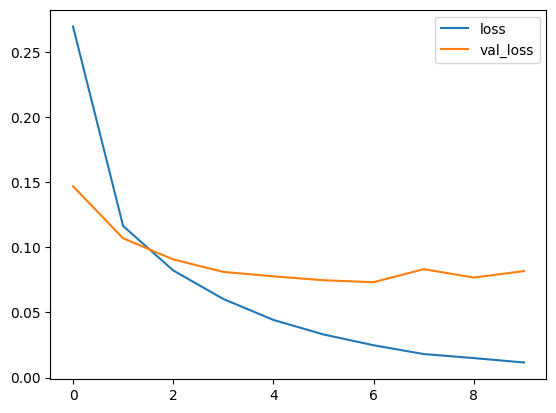

In [93]:
rnn = keras.Sequential()
rnn.add(keras.layers.Input((X_train_window.shape[1], X_train_window.shape[2])))
rnn.add(keras.layers.SimpleRNN(6, input_shape=(X_train_window.shape[1], X_train_window.shape[2]), return_sequences=True))
rnn.add(keras.layers.Flatten())
rnn.add(keras.layers.Dense(128, activation='relu'))
rnn.add(keras.layers.Dense(6, activation='softmax'))

rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(rnn, train_X, train_y, val_X, val_y)

In [94]:
cnn_test_results(rnn, X_test_window, y_test_window)

dws: 94.00581525385819%
ups: 91.65470208183775%
sit: 95.29213753306082%
std: 94.56174809722563%
wlk: 93.65786240786241%
jog: 89.41354394219458%
total: 93.86733227441192%


### Model Visualisation 

In [95]:
import visualkeras

visualkeras.layered_view(model, scale_xy=1, scale_z=0.5)

In [103]:
# graph the improvment of rolling features on decision tree, random forest, and neural network

dts_inital = test_results(dtc, test_df)
dts_rolling = test_results(rdt, rolling_test_fd)

rfc_inital = test_results(rfc, test_df)
rfc_rolling = test_results(rrfc, rolling_test_fd)

nn_inital = nn_test_results(model, test_df)
nn_rolling = nn_test_results(rolling_nn, rolling_test_fd)

dws: 47.59576926495422%
ups: 51.53700596236924%
sit: 94.72152591696201%
std: 87.43796792099104%
wlk: 59.24898884667239%
jog: 60.366506153023%
Total: 75.99262564910279%
dws: 90.10686699820126%
ups: 88.07407103937072%
sit: 91.63557863531004%
std: 99.71542474779199%
wlk: 85.44882604747698%
jog: 89.35523114355232%
Total: 91.87106019966497%
dws: 61.27455337303351%
ups: 59.50944339319505%
sit: 95.01733559992701%
std: 91.59427038021836%
wlk: 70.08824610859173%
jog: 71.9234884965222%
Total: 81.88908903834722%
dws: 98.58745106337953%
ups: 94.55528698430906%
sit: 99.9910466469693%
std: 96.28257553421953%
wlk: 90.4024516798547%
jog: 95.99300486618006%
Total: 96.29525626252747%
dws: 49.37338903208604%
ups: 46.61358848941411%
sit: 89.36717857108556%
std: 92.1971302888091%
wlk: 76.19653143767619%
jog: 69.95385232744783%
total: 79.38983582715535%
dws: 94.55084118082743%
ups: 89.79474783891189%
sit: 90.46666865630067%
std: 95.59677481380831%
wlk: 91.47749383837073%
jog: 96.44540754257908%
total: 92.66

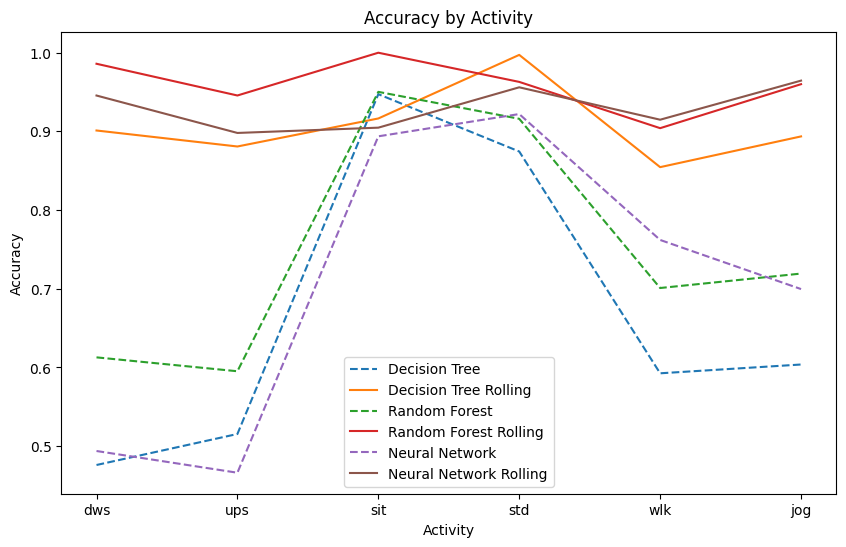

In [106]:
# dotted line is the initial model

plt.figure(figsize=(10, 6))
plt.plot(activities, dts_inital, label='Decision Tree', linestyle='--')
plt.plot(activities, dts_rolling, label='Decision Tree Rolling')
plt.plot(activities, rfc_inital, label='Random Forest', linestyle='--')
plt.plot(activities, rfc_rolling, label='Random Forest Rolling')
plt.plot(activities, nn_inital, label='Neural Network', linestyle='--')
plt.plot(activities, nn_rolling, label='Neural Network Rolling')

plt.legend()
plt.xlabel('Activity')
plt.ylabel('Accuracy')
plt.title('Accuracy by Activity')
plt.show()

In [163]:
X_train_window, y_train_window = sliding_window(train_df, window_size=300, stride_size=10)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False, window_size=300, stride_size=10)
X_test_window_cat, y_test_window_cat = sliding_window(test_df, window_size=300, stride_size=10)

Epoch 1/10
405/405 [==============================] - 13s 30ms/step - loss: 0.4914 - accuracy: 0.9057 - val_loss: 0.1749 - val_accuracy: 0.9729
Epoch 2/10
405/405 [==============================] - 13s 33ms/step - loss: 0.1697 - accuracy: 0.9724 - val_loss: 0.1150 - val_accuracy: 0.9849
Epoch 3/10
405/405 [==============================] - 11s 27ms/step - loss: 0.1725 - accuracy: 0.9734 - val_loss: 0.1049 - val_accuracy: 0.9855
Epoch 4/10
405/405 [==============================] - 10s 25ms/step - loss: 0.1121 - accuracy: 0.9815 - val_loss: 0.0903 - val_accuracy: 0.9868
Epoch 5/10
405/405 [==============================] - 10s 25ms/step - loss: 0.1090 - accuracy: 0.9839 - val_loss: 0.0959 - val_accuracy: 0.9864
Epoch 6/10
405/405 [==============================] - 10s 25ms/step - loss: 0.1182 - accuracy: 0.9834 - val_loss: 0.0923 - val_accuracy: 0.9918
Epoch 7/10
405/405 [==============================] - 10s 24ms/step - loss: 0.1004 - accuracy: 0.9857 - val_loss: 0.1438 - val_accuracy:

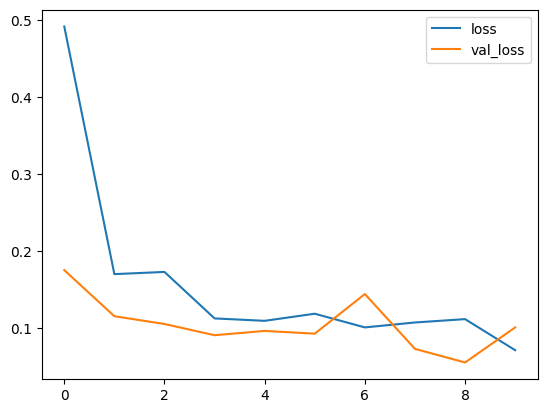

In [130]:
cnn_sliding_300 = keras.Sequential()

cnn_sliding_300.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding_300.add(keras.layers.MaxPooling1D(2))
cnn_sliding_300.add(keras.layers.Dropout(0.2))
cnn_sliding_300.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding_300.add(keras.layers.MaxPooling1D(2))
cnn_sliding_300.add(keras.layers.Dropout(0.2))
cnn_sliding_300.add(keras.layers.Flatten())
cnn_sliding_300.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_300.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_300.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding_300, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding_300, train_X, train_y, val_X, val_y, epochs=10)

In [148]:
cnn_sliding_300_results = cnn_test_results(cnn_sliding_300, X_test_window, y_test_window)

dws: 92.16569113012156%
ups: 100.0%
sit: 99.88441533423233%
std: 95.54790308695117%
wlk: 91.84238879482838%
jog: 93.58108108108108%
total: 96.15314604696317%


In [167]:
X_train_window, y_train_window = sliding_window(train_df, window_size=100, stride_size=10)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False, window_size=100, stride_size=10)
X_test_window_cat, y_test_window_cat = sliding_window(test_df, window_size=100, stride_size=10)

Epoch 1/10
406/406 [==============================] - 6s 14ms/step - loss: 0.4464 - accuracy: 0.8985 - val_loss: 0.1969 - val_accuracy: 0.9663
Epoch 2/10
406/406 [==============================] - 5s 13ms/step - loss: 0.1869 - accuracy: 0.9655 - val_loss: 0.1516 - val_accuracy: 0.9751
Epoch 3/10
406/406 [==============================] - 5s 13ms/step - loss: 0.1732 - accuracy: 0.9682 - val_loss: 0.1699 - val_accuracy: 0.9704
Epoch 4/10
406/406 [==============================] - 6s 14ms/step - loss: 0.1565 - accuracy: 0.9698 - val_loss: 0.1423 - val_accuracy: 0.9745
Epoch 5/10
406/406 [==============================] - 5s 12ms/step - loss: 0.1514 - accuracy: 0.9721 - val_loss: 0.1554 - val_accuracy: 0.9746
Epoch 6/10
406/406 [==============================] - 4s 11ms/step - loss: 0.1601 - accuracy: 0.9708 - val_loss: 0.1370 - val_accuracy: 0.9746
Epoch 7/10
406/406 [==============================] - 4s 11ms/step - loss: 0.1429 - accuracy: 0.9726 - val_loss: 0.1162 - val_accuracy: 0.9803

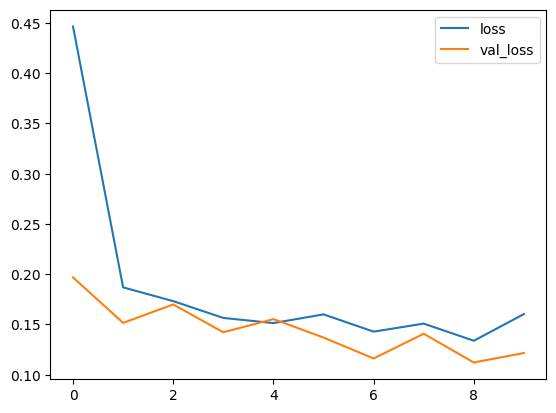

In [133]:
cnn_sliding_100 = keras.Sequential()

cnn_sliding_100.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding_100.add(keras.layers.MaxPooling1D(2))
cnn_sliding_100.add(keras.layers.Dropout(0.2))
cnn_sliding_100.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding_100.add(keras.layers.MaxPooling1D(2))
cnn_sliding_100.add(keras.layers.Dropout(0.2))
cnn_sliding_100.add(keras.layers.Flatten())
cnn_sliding_100.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_100.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_100.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding_100, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding_100, train_X, train_y, val_X, val_y, epochs=10)

In [150]:
cnn_sliding_100_results = cnn_test_results(cnn_sliding_100, X_test_window, y_test_window)

dws: 99.73226238286479%
ups: 87.06556789681117%
sit: 92.8283022495674%
std: 99.88958410011041%
wlk: 94.36857449746816%
jog: 95.46979865771812%
total: 95.09098603470166%


In [151]:
X_train_window, y_train_window = sliding_window(train_df, window_size=150, stride_size=10)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False, window_size=150, stride_size=10)
X_test_window_cat, y_test_window_cat = sliding_window(test_df, window_size=150, stride_size=10)

Epoch 1/10
406/406 [==============================] - 8s 19ms/step - loss: 0.4487 - accuracy: 0.9121 - val_loss: 0.2574 - val_accuracy: 0.9658
Epoch 2/10
406/406 [==============================] - 8s 19ms/step - loss: 0.1972 - accuracy: 0.9705 - val_loss: 0.1842 - val_accuracy: 0.9723
Epoch 3/10
406/406 [==============================] - 8s 19ms/step - loss: 0.1831 - accuracy: 0.9731 - val_loss: 0.1504 - val_accuracy: 0.9791
Epoch 4/10
406/406 [==============================] - 7s 18ms/step - loss: 0.1581 - accuracy: 0.9760 - val_loss: 0.1606 - val_accuracy: 0.9789
Epoch 5/10
406/406 [==============================] - 7s 18ms/step - loss: 0.1507 - accuracy: 0.9770 - val_loss: 0.1360 - val_accuracy: 0.9824
Epoch 6/10
406/406 [==============================] - 7s 17ms/step - loss: 0.1518 - accuracy: 0.9775 - val_loss: 0.1535 - val_accuracy: 0.9835
Epoch 7/10
406/406 [==============================] - 6s 15ms/step - loss: 0.1339 - accuracy: 0.9798 - val_loss: 0.1040 - val_accuracy: 0.9882

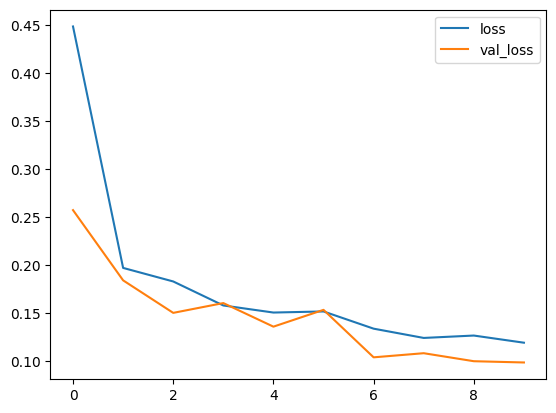

In [136]:
cnn_sliding_150 = keras.Sequential()

cnn_sliding_150.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding_150.add(keras.layers.MaxPooling1D(2))
cnn_sliding_150.add(keras.layers.Dropout(0.2))
cnn_sliding_150.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding_150.add(keras.layers.MaxPooling1D(2))
cnn_sliding_150.add(keras.layers.Dropout(0.2))
cnn_sliding_150.add(keras.layers.Flatten())
cnn_sliding_150.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_150.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_150.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding_150, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding_150, train_X, train_y, val_X, val_y, epochs=10)

In [152]:
cnn_sliding_150_results = cnn_test_results(cnn_sliding_150, X_test_window, y_test_window)

dws: 99.82110912343471%
ups: 87.04235463029433%
sit: 95.27748388958354%
std: 95.80162042720353%
wlk: 88.91277641277642%
jog: 95.39495798319328%
total: 93.77647343579814%


In [165]:
X_train_window, y_train_window = sliding_window(train_df, window_size=500, stride_size=10)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False, window_size=500, stride_size=10)
X_test_window_cat, y_test_window_cat = sliding_window(test_df, window_size=500, stride_size=10)

Epoch 1/10
405/405 [==============================] - 27s 61ms/step - loss: 0.6412 - accuracy: 0.8795 - val_loss: 0.2139 - val_accuracy: 0.9839
Epoch 2/10
405/405 [==============================] - 17s 42ms/step - loss: 0.1903 - accuracy: 0.9778 - val_loss: 0.2111 - val_accuracy: 0.9663
Epoch 3/10
405/405 [==============================] - 17s 41ms/step - loss: 0.1613 - accuracy: 0.9811 - val_loss: 0.1721 - val_accuracy: 0.9810
Epoch 4/10
405/405 [==============================] - 16s 40ms/step - loss: 0.1335 - accuracy: 0.9844 - val_loss: 0.0994 - val_accuracy: 0.9908
Epoch 5/10
405/405 [==============================] - 16s 40ms/step - loss: 0.1483 - accuracy: 0.9847 - val_loss: 0.0835 - val_accuracy: 0.9913
Epoch 6/10
405/405 [==============================] - 16s 40ms/step - loss: 0.0868 - accuracy: 0.9897 - val_loss: 0.1041 - val_accuracy: 0.9914
Epoch 7/10
405/405 [==============================] - 17s 41ms/step - loss: 0.0815 - accuracy: 0.9914 - val_loss: 0.0546 - val_accuracy:

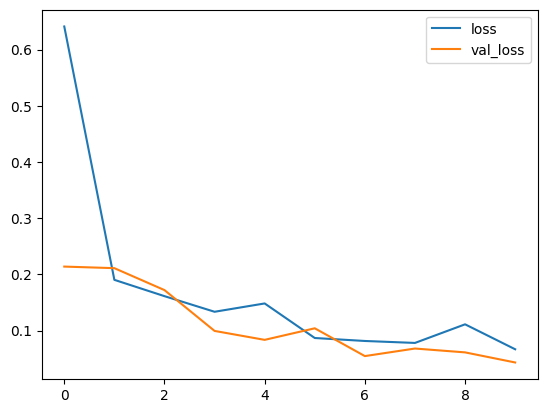

In [139]:

cnn_sliding_500 = keras.Sequential()

cnn_sliding_500.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding_500.add(keras.layers.MaxPooling1D(2))
cnn_sliding_500.add(keras.layers.Dropout(0.2))
cnn_sliding_500.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding_500.add(keras.layers.MaxPooling1D(2))
cnn_sliding_500.add(keras.layers.Dropout(0.2))
cnn_sliding_500.add(keras.layers.Flatten())
cnn_sliding_500.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_500.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding_500.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding_500, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding_500, train_X, train_y, val_X, val_y, epochs=10)

In [154]:
cnn_sliding_500_results = cnn_test_results(cnn_sliding_500, X_test_window, y_test_window)

dws: 99.95456610631531%
ups: 97.41912031988367%
sit: 100.0%
std: 96.09172728393538%
wlk: 90.05712521228963%
jog: 98.36734693877551%
total: 96.70848304000974%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


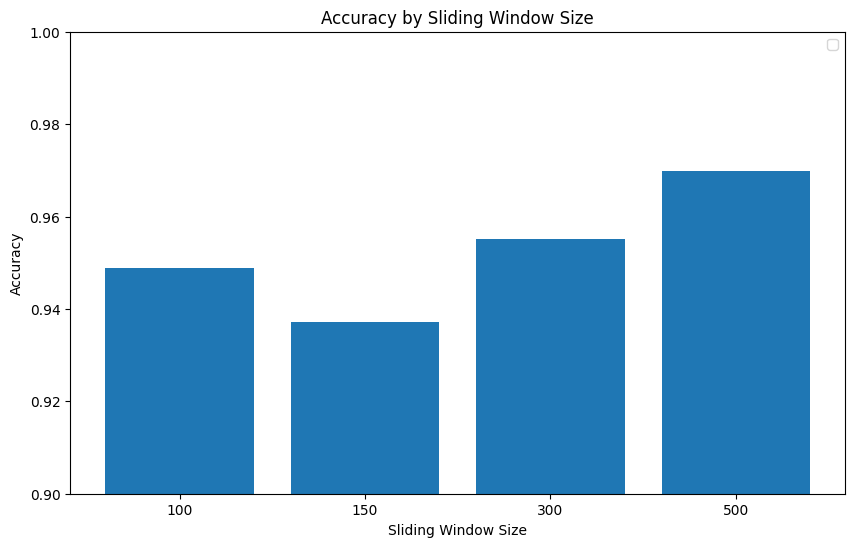

In [160]:
plt.figure(figsize=(10, 6))

# plot the average accuracy of each model as a bar chart
plt.bar(['100', '150', '300', '500'], [np.mean(cnn_sliding_100_results), np.mean(cnn_sliding_150_results), np.mean(cnn_sliding_300_results), np.mean(cnn_sliding_500_results)])

# adjust the scale of the y axis
plt.ylim(0.9, 1)

plt.legend()
plt.xlabel('Sliding Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy by Sliding Window Size')

plt.show()


In [161]:
def display_cnn_confusion_matrix(cnn, x_test, y_test):
    preds = cnn.predict(x_test, verbose=0)
    preds = np.argmax(preds, axis=1)
    encoder = LabelEncoder()
    encoder.fit(y_test)
    l = []
    for j in range(len(preds)):
        l.append(list(encoder.classes_)[preds[j]])
    
    y_true = y_test
    y_pred = l

    cm = confusion_matrix(y_true, y_pred, labels=activities)
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=activities)

    disp.plot()

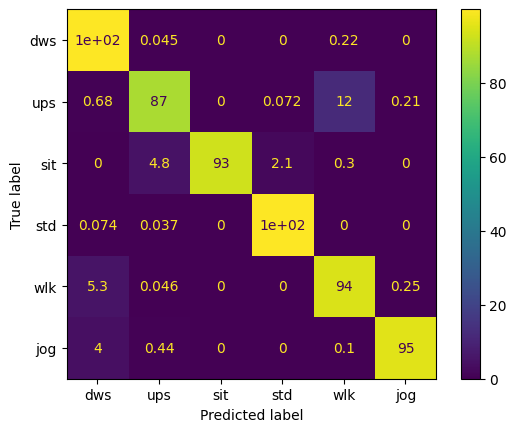

In [168]:
display_cnn_confusion_matrix(cnn_sliding_100, X_test_window, y_test_window)

In [ ]:
show_confusion_matrix(rrfc, )